# INTENT CLASSIFICATION AND OOS PREDICTIONS

The aim of the project is to classify queries into different intent classes or domains. Queries are very short sentences, usually some questions or prompt commands about specific topics.

The dataset includes also out-of-scope queries. By "out-of-scope", we mean queries that do not fall into any of the system-supported intent classes. We want also to analyse how the out-of-scope queries affects the performance of the system.

## Data Analysis

In [1]:
import pandas as pd
import json
import re
import nltk
import json
import gensim
import numpy as np
import time
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from operator import itemgetter
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


We load from the datset the train, validation and test set and we cast them as a Pandas Dataframe. We aggregate training and validation set to have more data for training, and we keep test set to evaluate the performance of the model.

In [2]:
with open('data_full.json') as json_file: 
    data_dict = json.load(json_file) 

train_data = data_dict['train'] # Data (In scope) for traning
val_data = data_dict['val'] # Data (In scope) for validation
test_data = data_dict['test'] # Data (In scope) for test

oos_train = data_dict['oos_train'] # Data  (Out of scope)for traning 
oos_val = data_dict['oos_val'] # Data (Out of scope) for validation
oos_test = data_dict['oos_test'] # Data (Out of scope) for testing


train_df = pd.DataFrame(train_data, columns =['query', 'intent'])
val_df = pd.DataFrame(val_data, columns =['query', 'intent'])
test_df = pd.DataFrame(test_data, columns =['query', 'intent'])

# concatenating validation and train set
frames = [train_df,val_df]
train_val_df = pd.concat(frames)

train_df.head()

,query,intent
0,what expression would i use to say i love you ...,translate
1,can you tell me how to say 'i do not speak muc...,translate
2,"what is the equivalent of, 'life is good' in f...",translate
3,"tell me how to say, 'it is a beautiful morning...",translate
4,"if i were mongolian, how would i say that i am...",translate


The paper related to this dataset is from November 2018, so the genre of the corpus is modern and the language used is English.

The provided dataset contains 23,700 queries, including 22,500 in-scope queries covering 150 intents, which can be grouped into 10 general domains. For each intent, there are 100 training, 20 validation and 30 testing queries.  

The dataset also included 1,200 out-of-scope queries. Of the 1,200 out-of-scope queries collected, 100 are used for validation and 100 are used for training, leaving 1,000 for testing.

Therefore, the dataset is very balanced between in-scope intent classes. Instead, it's very unbalanced between in-scope and out-of-scope training samples because we have 15,000 in-scope queries and only 100 out-of-scope queries. But if we consider out-of-scope as an intent class we have a dataset with 151 intents and very balanced. 

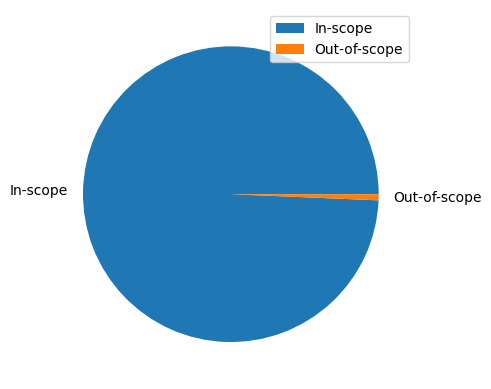

In [3]:
plt.pie([len(train_data), len(oos_train)],labels=['In-scope', 'Out-of-scope'])
plt.legend(loc='upper right')
plt.show()

The in-scope queries were collected using a scoping crowdsourcing task, which prompted crowd workers to provide questions and commands related to topic domains in the manner they would interact with an artificially intelligent assistant. Then data generated by scoping task were manually grouped into intents. 

Out-of-scope queries were collected in two ways. First, using worker mistakes: queries written for
one of the 150 intents that did not actually match any of the intents. Second, using scoping and
scenario tasks with prompts based on topic areas found on Quora, Wikipedia, and elsewhere. 

For all queries collected, all tokens were downcased, and all end-of-sentence punctuation was removed.
Additionally, all duplicate queries were removed and replaced.


## Pre-Processing 
The dataset is already partially pre-processed : all words are down cased and punctuations is removed. So we just need to remove special characters and lemmatize.

We can just pass the pre-processing function as argument to the vectorizer and then it will be applied to each word of the corpus analyzed by the vectorizer.

In [4]:
def preProcess(w):
    lemmatizer = WordNetLemmatizer()
    w = re.sub('[^a-zA-Z]', ' ', w)
    return lemmatizer.lemmatize(w)

## Word Analysis

We analyse the words in the corpus using Bag-of-Words and TF-IDF. 

When using TF-IDF we consider as document all the queries belonging to one intent class. So, we calculate the importance of each word in an intent by consider its frequency in the intent (TF) and its frequency in the entire corpus(IDF).

Meanwhile, Bag-of-Words model just considers the frequency of each word in the intent.

The following function **plot_top_n** simply uses Count Vectorizer or TF-IDF Vectorizer to count words frequencies and plots the result obtained in a bar chart together with a WordCloud.

In [5]:
def plot_top_n(corpus,keys, a_class, vectorizer, n):
    
    idx = keys.index(a_class)
    X = vectorizer.fit_transform(corpus).toarray()
    feat_val = list(zip(vectorizer.get_feature_names_out(), X[idx]))
    feat_val.sort(key=itemgetter(1), reverse=True)
    

    feat_val_top_n = feat_val[:n-1]
    feat_val_sep = list(zip(*feat_val_top_n))
    
    # only for plotting
    if type(vectorizer) == type(CountVectorizer()):
        vect = 'BAG OF WORDS'
    else :
        vect = 'TF-IDF'

    plt.figure(figsize=(10,5))
    plt.suptitle(f'{vect} - {a_class}')
    plt.subplot(1,2,1)

    if vect=='BAG OF WORDS':
        # plot's labels
        plt.xlabel("More relevant words")
        plt.ylabel("number of apperances")  
    else:
        plt.xlabel("More relevant words")
        plt.ylabel("TF-IDF SCORE")  


    # format the x values 
    plt.bar(feat_val_sep[0],feat_val_sep[1])
    plt.xticks(rotation=30, ha='right')
    if vect=='BAG OF WORDS':
        # Word Cloud
        word_list = [x for x in corpus[idx].split() if x != "ssss"]
        wordcloud = WordCloud().generate(" ".join(word_list))
        plt.subplot(1,2,2)
        plt.imshow(wordcloud)
        plt.axis('off')
        plt.show()


c:\Users\comas\venvpy3107\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(


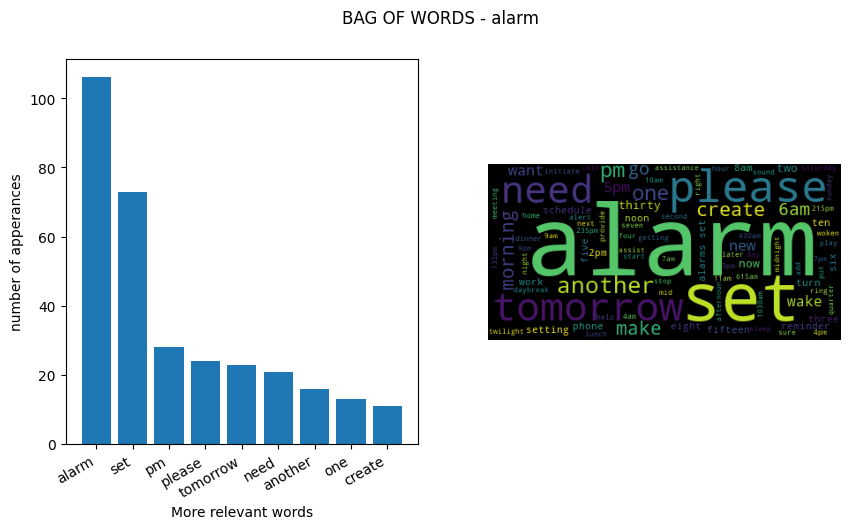

c:\Users\comas\venvpy3107\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(
c:\Users\comas\venvpy3107\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(


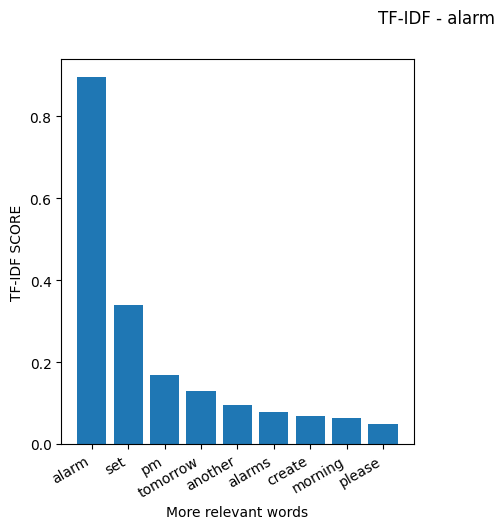

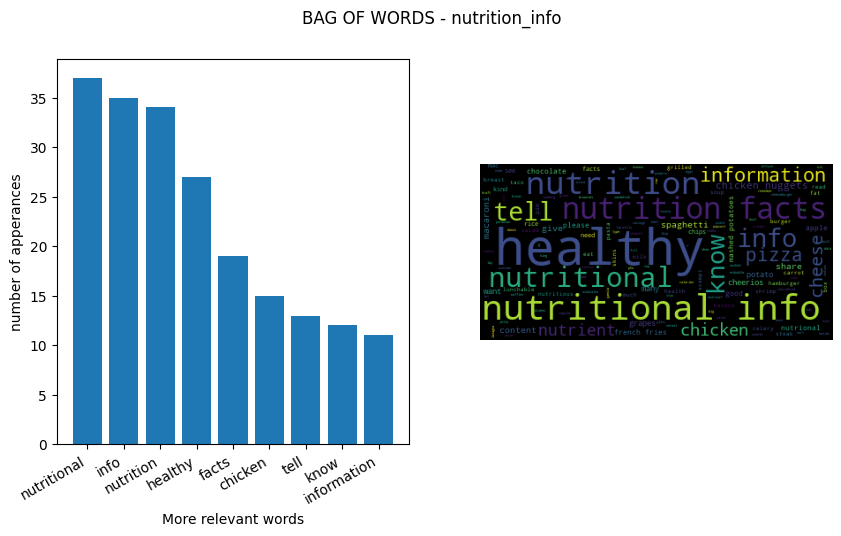

c:\Users\comas\venvpy3107\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(


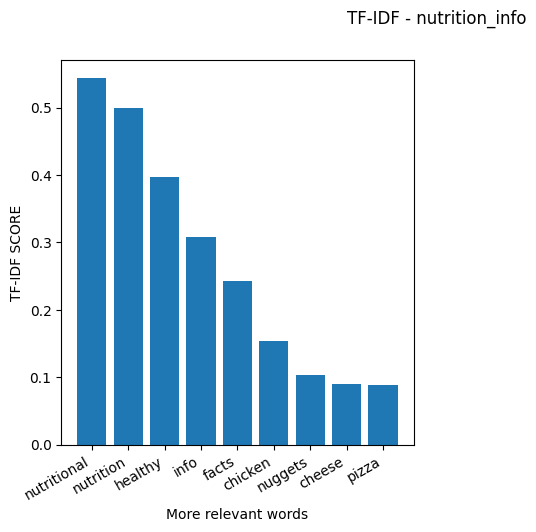

In [6]:
intents = train_val_df.groupby('intent')['query'].apply(lambda x: " ".join(x))
keys = list(intents.keys())
values = list(intents.values)

stop_words = stopwords.words('english')

for intent in ['alarm','nutrition_info']:
    
    n = 10

    plot_top_n(values, keys,intent, CountVectorizer(ngram_range=(1,1), preprocessor=preProcess, stop_words=stop_words), n)
    plot_top_n(values,keys, intent, TfidfVectorizer(ngram_range=(1,1), preprocessor=preProcess, stop_words=stop_words), n)


Using Bag-of-Words the most relevant words are the ones that appear more often in the intent class. Using instead TF-IDF the most relevant are the ones that appears often in the intent but that also they don't appear so often in all corpus. So, for example, we can see that *information* and *know* disappear from the most relevant words in the "*nutrition_info*" class using TF-IDF, probably because they're words that appear often in the intent class but they also appear very often in all corpus.

We can also notice that each intent can be distinguished very easily using just taking into account just a small portion of the most relevant words. Indeed, there are words that have a much bigger TF-IDF score compared to the others. For example, in the *alarm* intent class the word "*alarm*" has much bigger score compared to the others, and so it will be easy to classify a query as belonging to *alarm* intent when seeing that word.

## BASELINE

As a baseline method we chose the Bag of Words for feature extraction because it is simple and yet powerful. The chosen classifier model was Naive Bayes because it is also simple and usually produces stable results.


In [7]:
def get_df(oos=False,domains=False) :
    with open('data_full.json') as json_file: 
        data_dict = json.load(json_file) 

    train_data = data_dict['train']
    val_data = data_dict['val']
    test_data = data_dict['test']

    oos_train = data_dict['oos_train']
    oos_val = data_dict['oos_val']
    oos_test = data_dict['oos_test']


    train_df = pd.DataFrame(train_data, columns =['query', 'intent'])
    val_df = pd.DataFrame(val_data, columns =['query', 'intent'])
    test_df = pd.DataFrame(test_data, columns =['query', 'intent'])

    train_oos_df = pd.DataFrame(oos_train,columns=['query','intent'])
    val_oos_df = pd.DataFrame(oos_val,columns=['query','intent'])
    test_oos_df = pd.DataFrame(oos_test,columns=['query','intent'])

    if oos :
        # Concatenate dataframes to consider oos as a specific intent
        train_df = pd.concat([train_df,train_oos_df])
        val_df = pd.concat([val_df,val_oos_df])
        test_df = pd.concat([test_df,test_oos_df])
    
    train_df =pd.concat([train_df,val_df])

    if domains:
        with open('domains.json') as json_file:
            domain_dict = json.load(json_file)
        inv_domain_dict = {}
        for domainKey in domain_dict.keys():
            for intent in domain_dict[domainKey]:
                inv_domain_dict[intent] = domainKey
        if oos:
            inv_domain_dict['oos']='oos'
        train_df['domain'] = train_df.apply(lambda row: inv_domain_dict[row['intent']],axis=1)
        test_df['domain'] = test_df.apply(lambda row: inv_domain_dict[row['intent']],axis=1)
    
    return train_df, test_df

def predict_and_eval(df_test,x_test,model): 
    y_test = df_test['intent'].values
    y_pred = model.predict(x_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average="macro"))
    print("Recall:", recall_score(y_test, y_pred, average="macro"))
    print("F1:", f1_score(y_test, y_pred, average="macro"))


df_train, df_test = get_df(oos=False,domains=False)

Extracting features using BOW 

In [8]:
count_vectorizer = CountVectorizer()
X_train_BOF = count_vectorizer.fit_transform(df_train['query']).toarray()
X_test_BOF = count_vectorizer.transform(df_test['query']).toarray()

Training the Naive Bayes classifiers using the extracted features.

In [9]:
y_train = df_train['intent'].values
clf_log_int_BOF = MultinomialNB()
clf_log_int_BOF.fit(X_train_BOF, y_train)

MultinomialNB()

In [10]:
predict_and_eval(df_test,X_test_BOF,clf_log_int_BOF)

Accuracy: 0.8653333333333333
Precision: 0.8750724217199579
Recall: 0.8653333333333334
F1: 0.8633089030934745


We are quite satisfied with the results obtained by our baseline. But let's try to improve the performances using different features (TF-IDF and word embdeddings) and different classifiers

## USING TF-IDF



Here we just replace BOW with TF-IDF maintaining the same Naive Bayes classifier.

In [11]:
tfidf_vectorizer = TfidfVectorizer()
X_train_TFIDF = tfidf_vectorizer.fit_transform(df_train['query']).toarray()
X_test_TFIDF = tfidf_vectorizer.transform(df_test['query']).toarray()

y_train = df_train['intent'].values
clf_log_int_BOF = MultinomialNB()
clf_log_int_BOF.fit(X_train_BOF, y_train)

predict_and_eval(df_test,X_test_BOF,clf_log_int_BOF)

Accuracy: 0.8653333333333333
Precision: 0.8750724217199579
Recall: 0.8653333333333334
F1: 0.8633089030934745


We didn't see significant improvements using TF-IDF instead of BOW.

## WORD EMBEDDINGS 

After sparse representations we tried to use dense representation techniques using word embedding. We tried two different approach : the first one training our own word embeddings using the training set we had, and the second one using pre-trained word embeddings.

Here we use the Gaussian Naive Bayes classifier because the Multinomial one works only with discrete (and non negative) features. 

In [12]:
df_train, df_test = get_df(oos=False,domains=False)

In the first step we pre-process our data. This step included only lemmatization and removing of special characters. Other pre-processing operations are not necessary because our dataset contains sentences already downcased and without punctuation.

In [13]:
def utils_preprocess_text(text):
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
                
    ## Lemmatisation 
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    lst_text = [lem.lemmatize(word) for word in lst_text]

    ## removing special characters
    lst_text = [re.sub('[^a-zA-Z]', ' ', w) for w in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [14]:
# Apply preprocessing
df_train["query_clean"] = df_train["query"].apply(utils_preprocess_text)
df_test["query_clean"] = df_test["query"].apply(utils_preprocess_text)

### TRAINING WORD EMBEDDINGS


We use Word2Vec as model for training word embeddings and in particular we use the implementation given by the Gensim library.

To train our word embeddings using the train set we need to transform each row of the corpus into a list of unigrams. This is done by the function *corpus_as_lst(corpus)* .

In [15]:
def corpus_as_lst(corpus):
   ## create list of lists of unigrams
   lst_corpus = []
   for string in corpus:
      lst_words = string.split()
      lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
      lst_corpus.append(lst_grams)
   return lst_corpus

# Prepare the corpus to be trained by Word2Vec
train_corpus = corpus_as_lst(df_train['query_clean'])


Then we feed the Word2Vec model with the corpus transformed into a list of lists. We specify some parameters , in particular :
- *vector_size* is the size of each word embedding vector.
- *window* is the size of the window of words near the target word, that are implicitly considered as positive.
- *sg=1* indicates that we want to use skip-gram as training algorithm.
- *min_count=1* ignores all words with total frequency lower than 1.
- *epochs* is the number of iterations over the corpus

In [16]:
# Training word embeddings
wc_model = gensim.models.word2vec.Word2Vec(train_corpus, vector_size=300,   window=8, min_count=1, sg=1, epochs=30)

Now that we have the word embeddings, we want to transform each sentence into a word vector. This is done using the **text_to_mean(embeddings,text)** function which takes as inputs the word embeddings and a sentence. 

First of all it splits into tokens the sentence and for each token searches for the corresponding word vector. If the word is not present into the word embdeddings vocabulary it simply ignores it. 

At this point we have a NxM matrix where N is the number of words composing the sentence and M is the size of word vector (in our case 300). 

But we want to obtain only one vector for each sentence. So we simply take the mean along columns and we return the corresponding vector.

The function *get_word_embeddings(corpus)* simply computes the *text_to_mean* function to all sentences of the corpus.

In [17]:
def text_to_mean_vector(embeddings, text):
    tokens = text.split()
    vec = []
    for i in range(len(tokens)):
        try:
            vec.append(embeddings.get_vector(tokens[i]))
        except KeyError:
            True   # simply ignore out-of-vocabulary tokens
    if(len(vec)!=0):
        return [sum([row[j] for row in vec]) / len(vec) for j in range(len(vec[0]))]
    else : 
        return []  # if every token of the sentence is out-of-vocabulary we simply return an empty list

def get_word_embdeddings(corpus, model):
    embeddings_corpus = []
    for c in corpus:
        mean_vec = text_to_mean_vector(model, c)
        if(len(mean_vec)!=0):
            embeddings_corpus.append(mean_vec)
        else:
            embeddings_corpus.append(np.zeros(model.vector_size,)) # if every token of the sentence is out-of-vocabulary we represents that sentence as a list of zeros
    return np.array(embeddings_corpus)


In [18]:
# Extracting word embeddings
X_train = get_word_embdeddings(df_train['query_clean'], wc_model.wv)
X_test = get_word_embdeddings(df_test['query_clean'], wc_model.wv)

print(X_train.shape)
print(X_test.shape)


(18000, 300)
(4500, 300)


In [19]:

def train_model(model,X_train,df_train,df_test,domains=False):
        # Getting labels
    if domains:
        y_train = df_train['domain'].values
        y_test = df_test['domain'].values
    else:
        y_train = df_train['intent'].values
        y_test = df_test['intent'].values
        
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return y_pred,y_test

# Training 
nb = GaussianNB()
y_pred,y_test=train_model(nb,X_train,df_train,df_test,domains=False)

# Evaluating
predict_and_eval(df_test,X_test,nb)

Accuracy: 0.8126666666666666
Precision: 0.8336374304574844
Recall: 0.8126666666666668
F1: 0.8167652002407262


### USING PRE-TRAINED WORD EMBEDDINGS

Instead of training our word embeddings we can also use pre-trained word embeddings. We use **word2vec-google-news-300** pre-trained vectors which are trained on a part of the Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases.

In [20]:
# we load pretrained word embeddings
google_300 = gensim.models.KeyedVectors.load("./models/google_300")

In [21]:
# Extracting word embeddings
X_train = get_word_embdeddings(df_train['query_clean'], google_300)
X_test = get_word_embdeddings(df_test['query_clean'], google_300)

print(X_train.shape)
print(X_test.shape)


# Training 
nb = GaussianNB()
y_pred,y_test=train_model(nb,X_train,df_train,df_test,domains=False)

# Evaluating
predict_and_eval(df_test,X_test,nb)

(18000, 300)
(4500, 300)
Accuracy: 0.784
Precision: 0.8182462826107042
Recall: 0.7839999999999999
F1: 0.7926914725433356


We notice that the performance using pre-trained word embeddings are worse than using the ones trained by us. This probably happens because we train our word embeddings using the train set which is similar to the test set in the sentences' structure. The pre-trained ones instead are trained on a corpus, even if bigger, that is slightly different.

It's interesting to notice also that we obtain worst results using word embdedding as features rather than sparse represenations (BOW or TF-IDF). This probably happens because the sentences that we want to classify are very short and not so articulated, so they're more represented by individual words than by relations between words in the same sentence. 

## TRYING DIFFERENT CLASSIFIERS
Now we'll try to use different classifiers to see the difference of performances between them. We'll use sparse representations for features because they lead to better results.

We'll also analyze how out-of-scope queries affects the performance.

In [22]:
df_train, df_test = get_df(oos=False,domains=True)


We evaluate the following classifiers

In [23]:
models = [
    LogisticRegression(multi_class='multinomial', max_iter=300),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(max_depth=2, random_state=0),
    GaussianNB()
]
model_names = [
    "   Logistic Regression",
    "         Decision Tree",
    "         Random Forest",
    "  Gaussian Naive Bayes"
]

In [24]:
def train_model(model, X_train, df_train, df_test, domains = False):
    y_train = (df_train['domain'].values) if domains else (df_train['intent'].values)
    start_time = time.time()
    model = model.fit(X_train, y_train)
    print("%s seconds"% (time.time() - start_time))
    return model

def predic_of_model(model_fited, X_test, domains = False):
    y_test = df_test['domain'].values if domains else df_test['intent'].values
    y_pred = model_fited.predict(X_test)
   
    return y_pred, y_test, X_test

#### Fit chosen classifiers

In [25]:
for model, name in zip(models, model_names):
    train_model(model, X_train_TFIDF, df_train, df_test, domains = False)
    print("finished train model: ", name)

99.19437456130981 seconds
finished train model:     Logistic Regression


### Report the classifiers results


In [ ]:
def printReport(model, name, X_test, y_test, y_pred, all_classes =False):
    print("################# " + name.upper() + '#################')
    # score
    print(name + ": {:.4f}%".format(model.score(X_test, y_test) * 100))
    # confusion matrix
    print(confusion_matrix(y_test, y_pred))
    # report
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average="macro"))
    print("Recall:", recall_score(y_test, y_pred, average="macro"))
    print("F1:", f1_score(y_test, y_pred, average="macro"))
    if all_classes:
        print(classification_report(y_test, y_pred))

Print the report and confusion matrix of each chosen model

In [ ]:
for fited_model, name in zip(models, model_names):
    y_pred, y_test, X_test = predic_of_model(fited_model, domains = False)
    printReport(fited_model, name, X_test, y_test, y_pred)
    

? is the model obtaining the best performance

## CONSIDERING OOS QUERIES

Now we evaluate how the OOS samples affect the performance of the model. We'll use ? which is the best performing model.

In [ ]:
# Considering also oos 
df_train, df_test = get_df(oos=True,domains=True)

# Training the model
model = LogisticRegression(multi_class='multinomial', max_iter=300)
train_model(model, X_train_TFIDF, df_train, df_test, domains = False)

# Predictions
y_pred, y_test, X_test = predic_of_model(model, domains = False)

# Report
printReport(model, 'Logistic Regression', X_test, y_test, y_pred, all_classes=True)